In [ ]:
! pip install matplotlib seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os

# Set the download directory to your external disk
os.environ['GENSIM_DATA_DIR'] = "/media/martin/martin_work/gensim-data"


import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load pretrained Word2Vec Google News model (300 dimensions)
model = api.load("word2vec-google-news-300")  # ~1.5GB, downloads once


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
# Define synonym lists
good_words = ['good', 'great', 'excellent', 'awesome', 'fantastic', 'amazing', 'superb', 'positive']
bad_words = ['bad', 'terrible', 'awful', 'horrible', 'dreadful', 'poor', 'worst', 'negative']

# Filter OOV words
good_words = [w for w in good_words if w in model]
bad_words = [w for w in bad_words if w in model]

# Get embeddings
good_vecs = np.array([model[w] for w in good_words])
bad_vecs = np.array([model[w] for w in bad_words])

# Min-max normalization row-wise
def minmax_normalize_rows(vectors):
    min_vals = vectors.min(axis=1, keepdims=True)
    max_vals = vectors.max(axis=1, keepdims=True)
    denom = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    return (vectors - min_vals) / denom

normalized_good_vecs = minmax_normalize_rows(good_vecs)
normalized_bad_vecs = minmax_normalize_rows(bad_vecs)

# Average vectors
avg_good = normalized_good_vecs.mean(axis=0)
avg_bad = normalized_bad_vecs.mean(axis=0)
abs_diff = np.abs(avg_good - avg_bad)



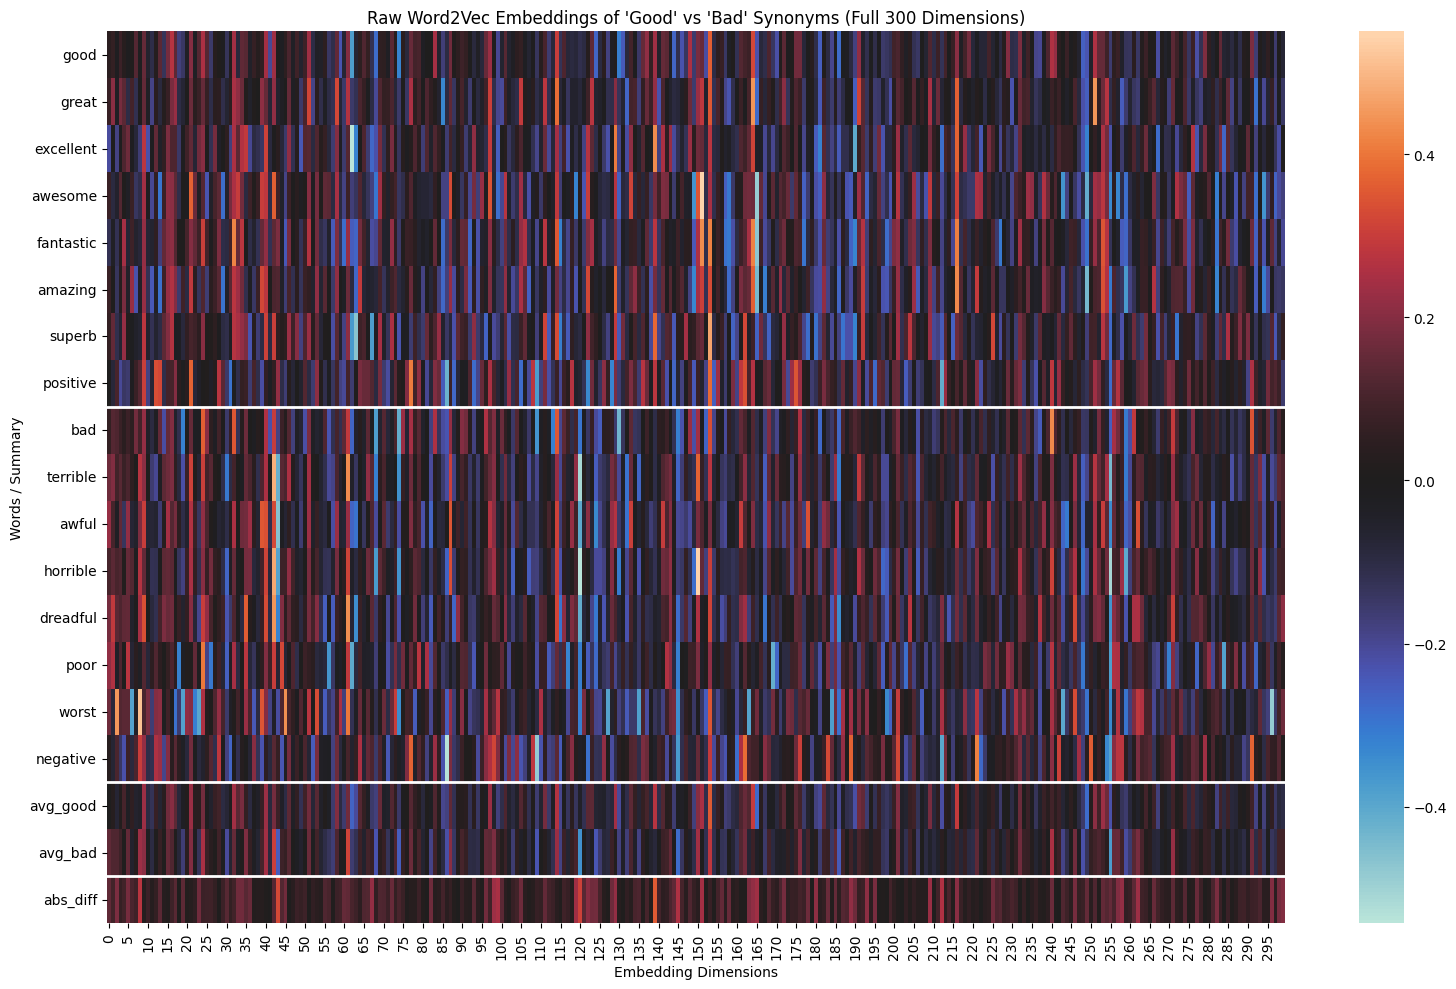

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Compute average and absolute difference on raw vectors ---
avg_good = good_vecs.mean(axis=0)
avg_bad = bad_vecs.mean(axis=0)
abs_diff = np.abs(avg_good - avg_bad)

# --- Stack all vectors: good, bad, averages, diff ---
stacked = np.vstack([good_vecs, bad_vecs, avg_good, avg_bad, abs_diff])
row_labels = good_words + bad_words + ['avg_good', 'avg_bad', 'abs_diff']

# --- Plot heatmap of all 300 dimensions ---
plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    stacked,
    #cmap="coolwarm",
    center=0,
    yticklabels=row_labels
)

# === Horizontal separators ===
line_color = 'white'
line_width = 2

good_count = len(good_words)
bad_count = len(bad_words)
avg_count = 2  # avg_good, avg_bad

ax.axhline(y=good_count, color=line_color, linewidth=line_width)
ax.axhline(y=good_count + bad_count, color=line_color, linewidth=line_width)
ax.axhline(y=good_count + bad_count + avg_count, color=line_color, linewidth=line_width)

# Labels and layout
plt.title("Raw Word2Vec Embeddings of 'Good' vs 'Bad' Synonyms (Full 300 Dimensions)")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Words / Summary")
plt.tight_layout()
plt.show()



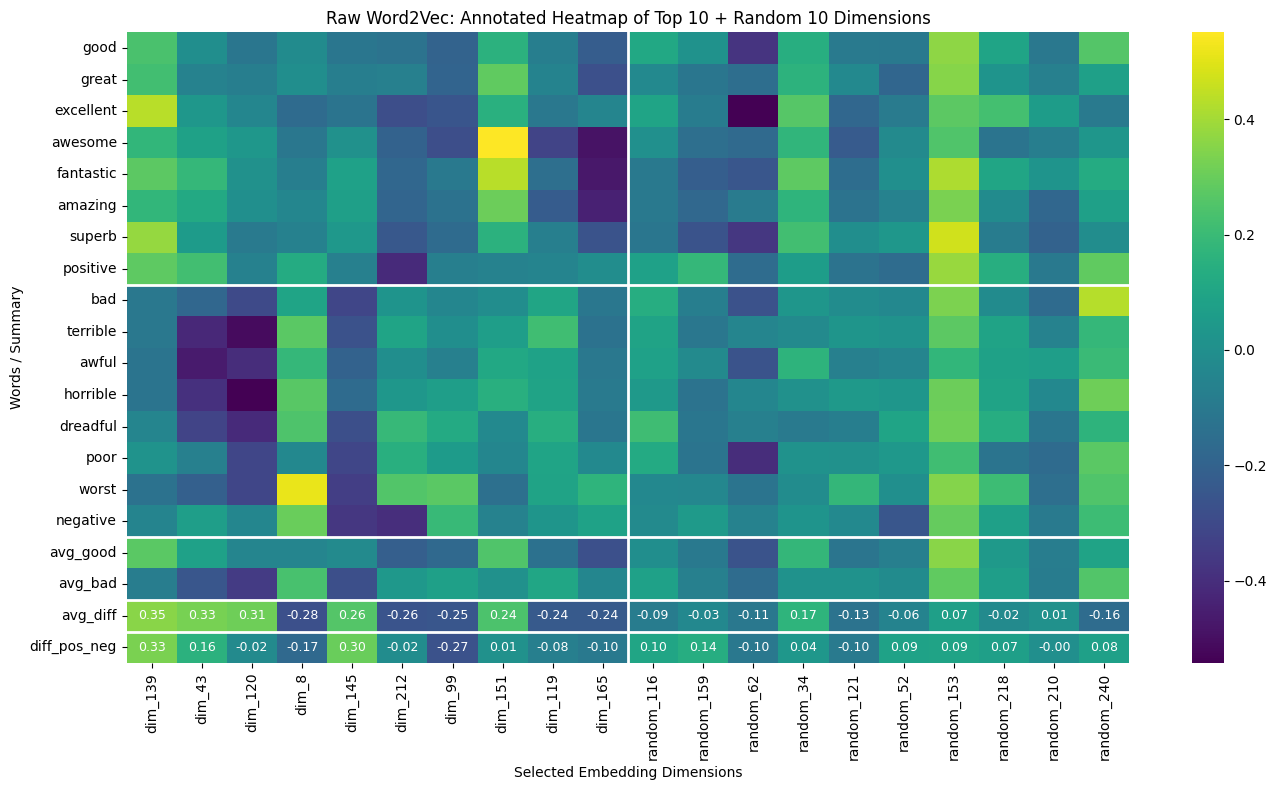

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Toggle: add 'positive' vs 'negative' difference ---
add_pos_neg_diff = True

# --- Compute raw average vectors and abs diff ---
avg_good = good_vecs.mean(axis=0)
avg_bad = bad_vecs.mean(axis=0)
avg_diff = avg_good - avg_bad

# Optional row: vec("positive") - vec("negative")
append_rows = []
append_labels = []

if add_pos_neg_diff and 'positive' in model and 'negative' in model:
    diff_pos_neg = model['positive'] - model['negative']
    append_rows.append(diff_pos_neg)
    append_labels.append("diff_pos_neg")

# --- Stack full set for selection ---
stacked = np.vstack([good_vecs, bad_vecs, avg_good, avg_bad, avg_diff] + append_rows)
row_labels = good_words + bad_words + ['avg_good', 'avg_bad', 'avg_diff'] + append_labels

# --- Select top + random dimensions for heatmap ---
top_n = 10
random_n = 10
dim = avg_good.shape[0]

top_diff_indices = np.argsort(np.abs(avg_diff))[-top_n:][::-1]
random_candidates = list(set(range(dim)) - set(top_diff_indices))
random_diff_indices = np.random.choice(random_candidates, size=random_n, replace=False)

selected_indices = np.concatenate([top_diff_indices, random_diff_indices])
selected_labels = [f'dim_{i}' for i in top_diff_indices] + [f'random_{i}' for i in random_diff_indices]

# Subset the matrix
subset = stacked[:, selected_indices]

# --- Create annotation matrix (only last 1 or 2 rows) ---
annot_matrix = np.full_like(subset, '', dtype=object)
annot_start = len(subset) - (1 + len(append_rows))
for i in range(annot_start, len(subset)):
    for j, val in enumerate(subset[i]):
        annot_matrix[i, j] = f"{val:.2f}"

# --- Plot ---
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    subset,
    cmap="viridis",
    yticklabels=row_labels,
    xticklabels=selected_labels,
    annot=annot_matrix,
    fmt='',
    annot_kws={"fontsize": 9, "color": "white", "ha": "center"}
)

# === Horizontal lines ===
line_color = 'white'
line_width = 2
good_count = len(good_words)
bad_count = len(bad_words)
avg_count = 2

ax.axhline(y=good_count, color=line_color, linewidth=line_width)
ax.axhline(y=good_count + bad_count, color=line_color, linewidth=line_width)
ax.axhline(y=good_count + bad_count + avg_count, color=line_color, linewidth=line_width)
if add_pos_neg_diff:
    ax.axhline(y=good_count + bad_count + avg_count + 1, color=line_color, linewidth=line_width)

# === Vertical separator ===
ax.axvline(x=top_n, color=line_color, linewidth=line_width)

# Final formatting
plt.title(f"Raw Word2Vec: Annotated Heatmap of Top {top_n} + Random {random_n} Dimensions")
plt.xlabel("Selected Embedding Dimensions")
plt.ylabel("Words / Summary")
plt.tight_layout()
plt.show()





OK, now let's do the same thing but with completely different word backgrounds

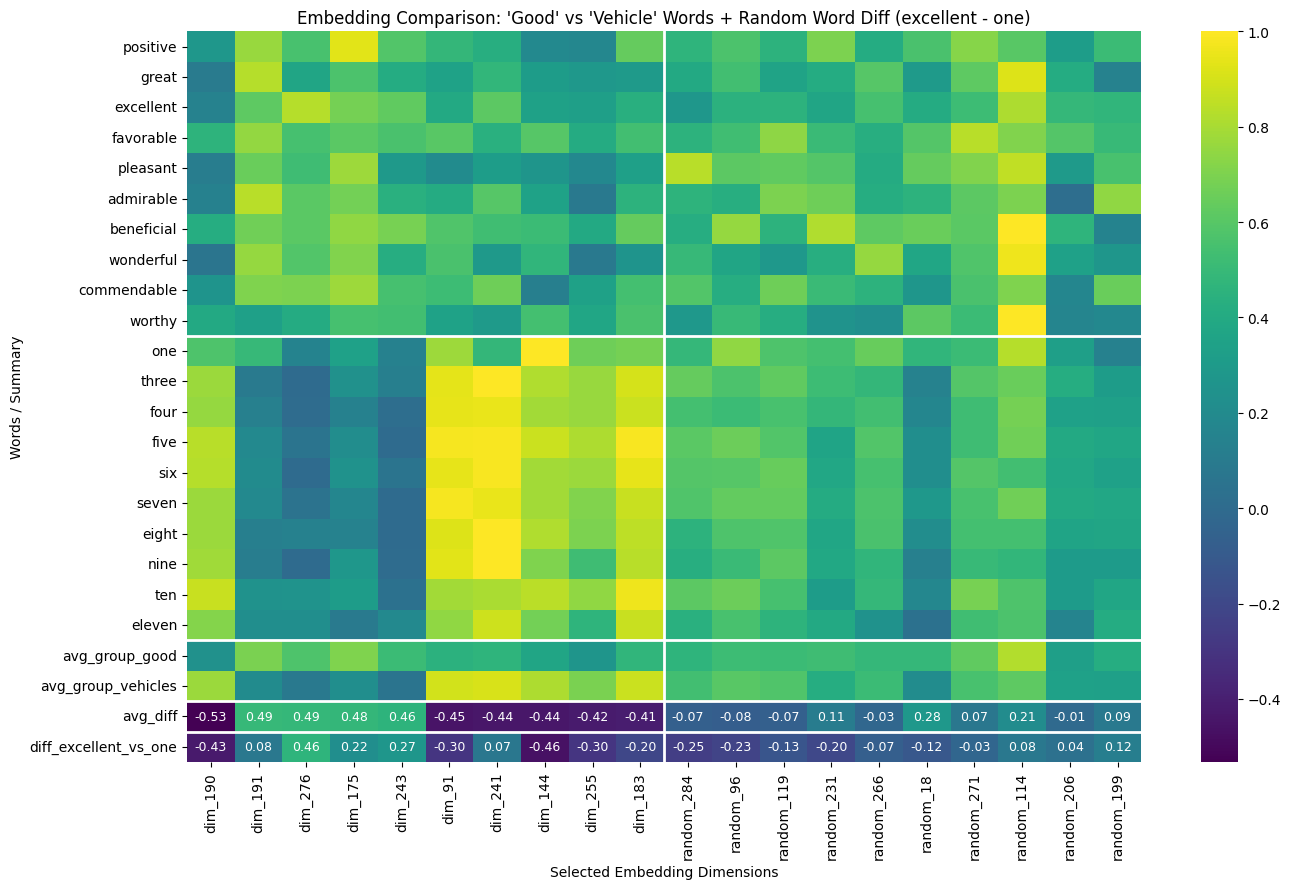

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Assume Word2Vec model is loaded as `model`
# model = api.load("word2vec-google-news-300")

# Define word groups
adj_words_list = [ "positive",
        "great",
        "excellent",
        "favorable",
        "pleasant",
        "admirable",
        "beneficial",
        "wonderful",
        "commendable",
        "worthy"]
veh_words_list = ["one",
        "three",
        "four",
        "five",
        "six",
        "seven",
        "eight",
        "nine",
        "ten",
        "eleven"]

# Filter OOV
adj_words = [w for w in adj_words_list if w in model]
veh_words = [w for w in veh_words_list if w in model]

# Get embeddings
adj_vecs = np.array([model[w] for w in adj_words])
veh_vecs = np.array([model[w] for w in veh_words])

# Normalize row-wise to [0, 1]
def minmax_normalize_rows(vectors):
    min_vals = vectors.min(axis=1, keepdims=True)
    max_vals = vectors.max(axis=1, keepdims=True)
    denom = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    return (vectors - min_vals) / denom

normalized_adj_vecs = minmax_normalize_rows(adj_vecs)
normalized_veh_vecs = minmax_normalize_rows(veh_vecs)

# Averages and diff
avg_adj = normalized_adj_vecs.mean(axis=0)
avg_veh = normalized_veh_vecs.mean(axis=0)
avg_diff = avg_adj - avg_veh

# Pick one random word from each group
word_a = random.choice(adj_words)
word_b = random.choice(veh_words)
diff_random = model[word_a] - model[word_b]  # no normalization

# Select top + random dimensions
top_n = 10
random_n = 10
dim = avg_adj.shape[0]

top_diff_indices = np.argsort(np.abs(avg_diff))[-top_n:][::-1]
random_candidates = list(set(range(dim)) - set(top_diff_indices))
random_diff_indices = np.random.choice(random_candidates, size=random_n, replace=False)

selected_indices = np.concatenate([top_diff_indices, random_diff_indices])
selected_labels = [f'dim_{i}' for i in top_diff_indices] + [f'random_{i}' for i in random_diff_indices]

# Stack and subset
stacked = np.vstack([normalized_adj_vecs, normalized_veh_vecs, avg_adj, avg_veh, avg_diff, diff_random])
subset = stacked[:, selected_indices]

# Row labels
row_labels = adj_words + veh_words + ['avg_group_good', 'avg_group_vehicles', 'avg_diff', f'diff_{word_a}_vs_{word_b}']

# Annotation matrix: only annotate last 2 rows
annot_matrix = np.full_like(subset, '', dtype=object)
for i in [-2, -1]:  # avg_diff and diff_random
    for j, val in enumerate(subset[i]):
        annot_matrix[i, j] = f"{val:.2f}"

# Plot
plt.figure(figsize=(14, 9))
ax = sns.heatmap(
    subset,
    cmap="viridis",
    yticklabels=row_labels,
    xticklabels=selected_labels,
    annot=annot_matrix,
    fmt='',
    annot_kws={"fontsize": 9, "color": "white", "ha": "center"}
)

# Horizontal lines
a_count = len(adj_words)
b_count = len(veh_words)
avg_count = 2

ax.axhline(y=a_count, color='white', linewidth=2)
ax.axhline(y=a_count + b_count, color='white', linewidth=2)
ax.axhline(y=a_count + b_count + avg_count, color='white', linewidth=2)
ax.axhline(y=a_count + b_count + avg_count + 1, color='white', linewidth=2)

# Vertical line between top and random dims
ax.axvline(x=top_n, color='white', linewidth=2)

# Labels
plt.title(f"Embedding Comparison: 'Good' vs 'Vehicle' Words + Random Word Diff ({word_a} - {word_b})")
plt.xlabel("Selected Embedding Dimensions")
plt.ylabel("Words / Summary")
plt.tight_layout()
plt.show()

